In [184]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import OneHotEncoder
import importlib


# import from custom package
from auxFuns.EDA import *
from auxFuns.modelling import *

In [183]:
import auxFuns.modelling 
importlib.reload(auxFuns.modelling )

<module 'auxFuns.modelling' from 'c:\\Users\\angel\\Documents\\VSCode\\rsv_modelling_transfer_learning\\auxFuns\\modelling.py'>

# 1. Exploration of ML algorithms and visualization of their decision boundaries
- Fitting various ML algorithms (linear, tree-based, distance-based)
- Interpretability and explanation

In [63]:
# Load data sets under study (VSCode)
raw_datasets_path = os.getcwd() + '/datasets/raw'
processed_datasets_path = os.getcwd() + '/datasets/processed'

rsv_predictors_phase1_df = pd.read_csv(raw_datasets_path + '/rsv_predictors_df_phase1_v3.csv')
rsv_predictors_phase1_daysDedup_df = pd.read_csv(processed_datasets_path + '/rsv_predictors_phase1_daysDedup.csv',low_memory=False)

# Load data sets under study (GColab)
# rsv_predictors_phase1_df = pd.read_csv('/content/rsv_predictors_df_phase1_v3.csv')
# rsv_predictors_phase1_daysDedup_df = pd.read_csv('/content/rsv_predictors_phase1_daysDedup.csv', low_memory=False)

In [191]:
rsv_predictors_phase1_df = make_it_categorical(rsv_predictors_phase1_df)
rsv_predictors_phase1_daysDedup_df = make_it_categorical(rsv_predictors_phase1_daysDedup_df)

rsv_predictors_phase1_df.shape, rsv_predictors_phase1_daysDedup_df.shape

# Extract a reduced sample of the data for modelling
sample_size = 80000
sample_rsv_df = rsv_predictors_phase1_df.sample(n = sample_size)
sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.sample(n = sample_size)

# sample_rsv_df = rsv_predictors_phase1_df.copy()
# sample_dedup_rsv_df = rsv_predictors_phase1_daysDedup_df.copy()

In [192]:
sample_rsv_df['RSV_test_result'].value_counts(), sample_dedup_rsv_df['RSV_test_result'].value_counts()

(RSV_test_result
 Negative    77562
 Positive     2438
 Name: count, dtype: int64,
 RSV_test_result
 Negative    77537
 Positive     2463
 Name: count, dtype: int64)

In [193]:
# 1. Transform the data and prepare it for modelling
df1 = sample_rsv_df.drop(
    ['patient_id', 'index_date', 'tendency_to_positivity', 'n_encounters'], axis = 1)

X_train_transformed, y_train, X_test_transformed, y_test, preprocessor_rsv = preprocess_rsv(df1, 
                                                                          input_test_size = 0.2, random_seed = 42
                                                                          )

In [194]:
# 2. Fit the model, specyfing a) model class b) hyperparameter_grid, target_scorer, number of cross-validation folds
model_class = RandomForestClassifier()
param_grid = {
    'n_estimators': [7, 14],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 4]
}
target_scorer = make_scorer(f1_score, average='macro')
n_cv_folds = 10

model1 = train_model_rsv(model = model_class, param_grid = param_grid, target_scorer = target_scorer, n_cv_folds = n_cv_folds,
                    X_train = X_train_transformed, y_train = y_train)


Training model ... RandomForestClassifier()
Best training parameters:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 14}
Best training f1-score:  0.6086109889390398


AUC Score: 0.7860537149281376
Precision / Positive predictive value: 0.7948717948717948
Specificity: 0.9989716562761103
Recall / sensitivity: 0.14058956916099774
Negative predictive value: 0.9761964577314408
Accuracy: 0.9753125
F-1: 0.23892100192678226


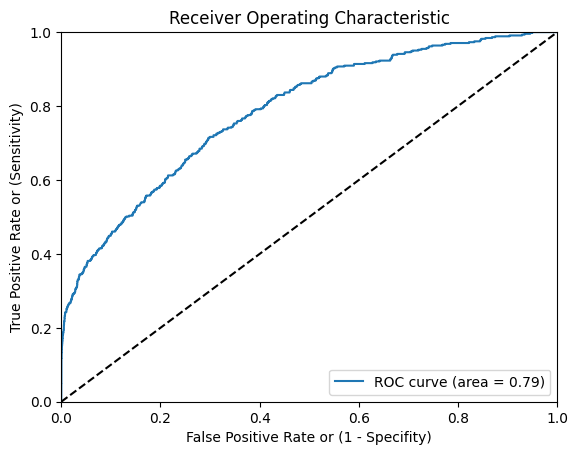

In [195]:
# 3. Evaluate the model

__,__,__,__,__,__,f1_score = calculate_performance_metrics_rsv(trained_model = model1, X_test = X_test_transformed, y_test = y_test, print_roc = True)

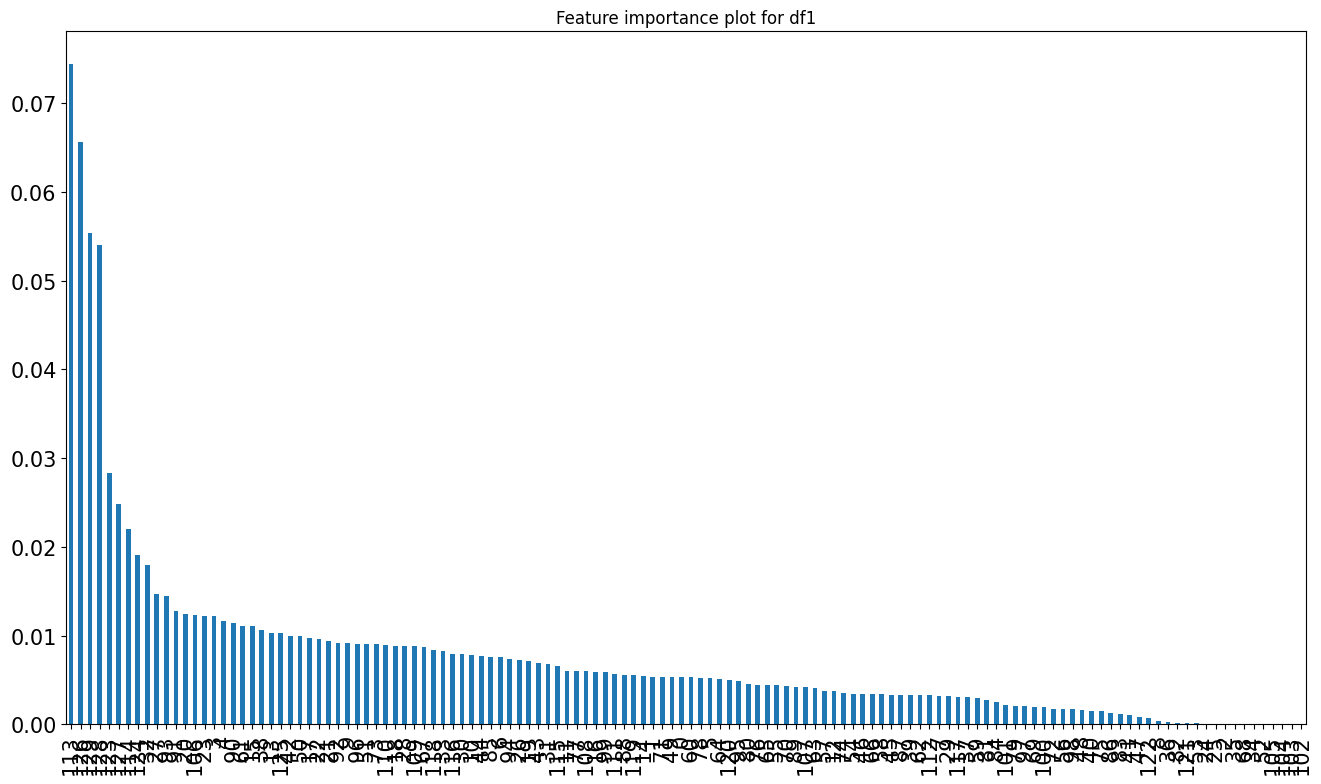

In [182]:
# Include a feature importance diagram for interpretability

best_rf1 = model1.best_estimator_

# Get feature importances
importances1 = best_rf1.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances1 = pd.Series(importances1)

# Sort the array in descending order of the importances
f_importances1.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances
f_importances1.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90, fontsize=15)

# Show the plot
# plt.tight_layout()
plt.title("Feature importance plot for df1")
plt.show()

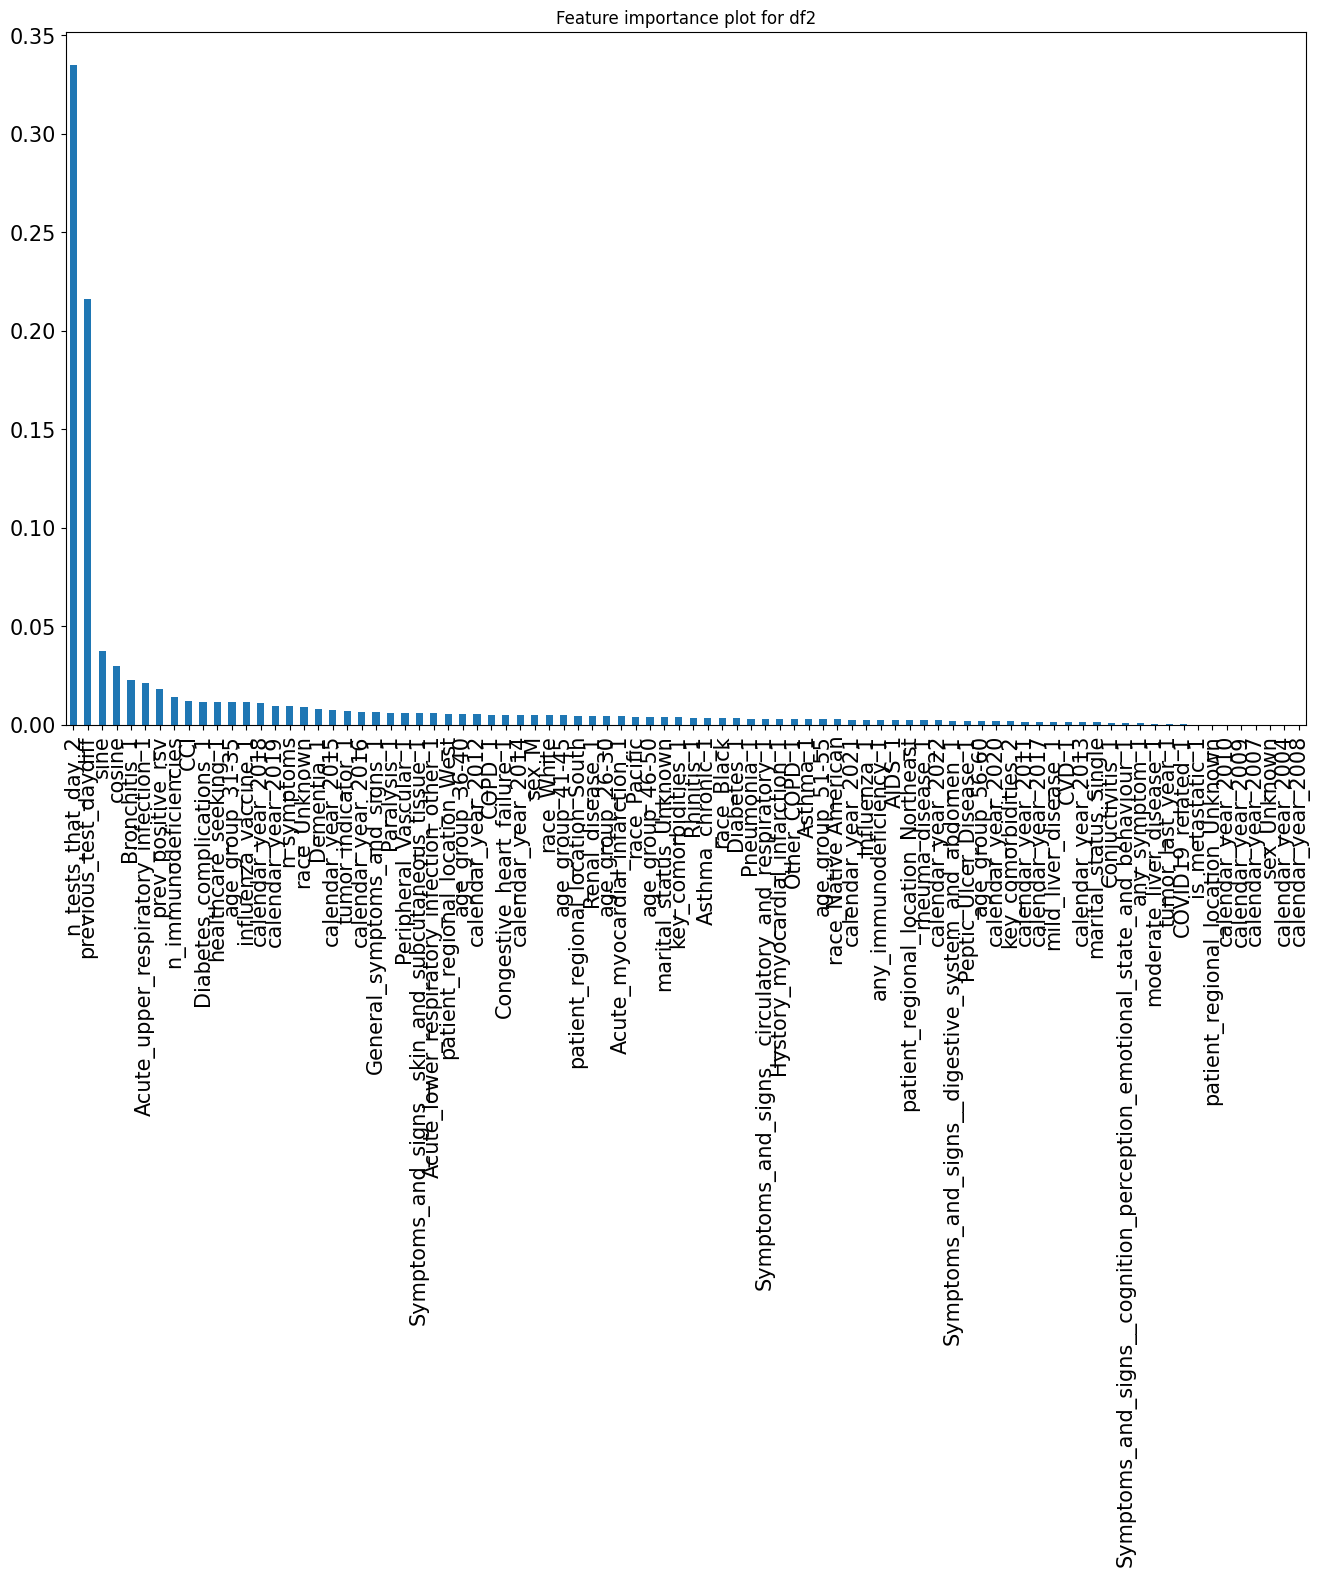

In [25]:
best_rf2 = grid_search2.best_estimator_

# Get feature importances
importances2 = best_rf2.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances2 = pd.Series(importances2, X2.columns)

# Sort the array in descending order of the importances
f_importances2.sort_values(ascending=False, inplace=True)

# Make the bar Plot from f_importances
f_importances2.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=90, fontsize=15)

# Show the plot
# plt.tight_layout()
plt.title("Feature importance plot for df2")
plt.show()